Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary).

Do not leave any variable initialized to None.

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

## Make sure to name your notebook file (.ipynb) correctly:
### - LAB4_NAMESURNAME_ID (E.g. : LAB4_MARIOROSSI_2204567)

## Fill in your name, surname and id number (numero matricola) below:

In [27]:
NAME = "NIHAL SURI"
ID_number = int("2141819")

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

Main Topics:
- Gradient Descent [GD]
- Stochastic Gradient Descent [SGD]
- Computational aspects of GD vs SGD

In this lab we will see how to solve the Empirical Risk Minimization [ERM] using iterative methods such as GD and SGD. We will focus on the computational aspects that make SGD a compelling algorithm w.r.t. GD.

Most of this lab will focus on linear models (since they are very easy to be handled and theoretically studied), nonetheless many ideas follow mutatis mutandis to non linear models and therefore to non convex optimization. 

We cannot stress enough how important SGD is in real world Machine Learning: it is the workhorse algorithm for convex and non convex optimization (especially in the large data regime) and has a countless number of applications, ranging from pure ML, to Robotics, Reinforcement Learning, Computer Vision, Recommendation Systems, etc ...

In [28]:
import numpy as np
import matplotlib.pyplot as plt

### Notation

Recall the notation we used so far to denote *generalization error* $L_\mathcal D(h)$ and training error $L_\mathcal S(h)$. The learning problem requires to find a function $\hat h$ that belongs to the model class $\mathcal H$ such that the generalization error is minimized. In practice, since we do not have access to $L_\mathcal D (h)$, we use the training error as a proxy to the generalization error, and find a candidate model $\hat h_{ERM} \in \mathcal H$.

$\hat h_{ERM}$ is found by solving the following optimization problem: 

$$
\hat h_{ERM} = \arg\min_{h \in \mathcal H} L_S(h) = \arg\min_{h \in \mathcal H} \frac{1}{m} \sum_{i=1}^{m} l(y_i, h(x_i))
$$

This problem is pretty general, the way we solve it **highly** depends on the model class and the loss we choose. Only in very _special_ cases we can find the optimal solution in closed form, e.g. considering linear models and taking the squared loss, we know the solution corresponds to the Least-Squares approach. Do not forget that in this case we are facing a *convex* optimization problem, which can be very well studied and understood.

Nonetheless, in a general ERM problem we are not guaranteed to have neither closed form solutions nor convexity. For example, with: 
- Logistic Regression, in which we have a convex problem whose solution cannot be written in closed form
- Deep Learning, in which the model class is the class of Deep Neural Networks and the loss is the Cross-Entropy Loss or squared loss (depending on the problem)  

For the sake of simplicity we will assume the model class $\mathcal H$ is parametrized by a vector of parameters $w$ (which univocally determine $h_w$ so we can simply write $L_\mathcal S (w)),$ moreover we will commit to the assumption that $L_\mathcal S(w)$ is **differentiable** w.r.t. $w$ (this working hypopthesis is important since we are going to compute gradients). 


## Gradient Descent

In order to solve ERM using GD we shall follow these steps: 
1. initialize $w^{(0)}$ (you can choose it randomly, based on your prior knowledge, or to zero)
2. at each iteration (indexed by t) update the parameter $w^{(t)}$ using the update rule below:

$$w^{(t+1)} = w^{(t)} - \eta \nabla L_\mathcal S (w^{(t)}) \qquad t=1,2,...$$

where $\eta$ is a positive number (which is usually chosen "small": what we consider "small" depends on the optimization problem you are solving).

The sequence of updates may be infinite but usually we explicitly choose a termination condition:
- the number of iterations to be performed
- the value of the loss under a certain threshold
- the magnitude of the gradient below a certain threshold
    
Once the termination condition is met we return the optimal parameter we found along the iterations. Once again we can choose different rules to return the best parameter (let $T$ be the number of iterations performed): 
- the last parameter $w^{(T)}$
- the average parameter of the last $K$ iterations
- the best performing vector we found (${\rm arg\;min}_{t \in [T]} L_S(w^{(t)})$)

**Problem:** Local minima. You may get stuck in local minima, since you are following the steepest descent direction every time. Therefore if you end up into a local minimum whose loss value is high (w.r.t. to the loss of the optimal parameter), it would be impossible to find a better solution to the optimization problem. 


## Stochastic Gradient Descent

The main idea behind SGD is to apply the very same update rule we described for GD but with a different gradient than $\nabla L_\mathcal S (w^{(t)})$. Denote the new gradient as $\hat {\nabla L_\mathcal S (w^{(t)})}$. Which are the properties that this different gradient must satisfy? 

We only require that $\hat {\nabla L_\mathcal S (w^{(t)})}$ is an *unbiased estimate* of $\nabla L_\mathcal S (w^{(t)})$, which means that: $\mathbb E[\hat {\nabla L_\mathcal S (w^{(t)})}] = \nabla L_\mathcal S (w^{(t)})$). But where does the randomness we consider come from? 
After all we are optimizing with respect to the training error, which is a **deterministic number** (since the training set is fixed). This randomness is introduced by SGD itself and has nothing to do with the randomness of our data.

To make it simple, a possible example of SGD gradient is the following: suppose you know the GD gradient $\nabla L_\mathcal S (w^{(t)})$ and in place of the GD update rule you decide to apply the following one: 

$$w^{(t+1)} = w^{(t)} - \eta \underbrace{(\nabla L_\mathcal S (w^{(t)}) + e_t)}_{\text{this is the SGD gradient}} \qquad t=1,2,...$$
where $e_t \sim \mathcal N(0, I)$, which is i.i.d. (i.e. no correlation with parameters or data). As you can see the gradients used to perform the update are now noisy (but the noise has been introduced only by the optimization algorithm, it does not concern the ERM before we choose to solve it using SGD).

If you now take the expectation $\mathbb E_{SGD}[\nabla L_\mathcal S (w^{(t)}) + e_t] = \mathbb E_{SGD}[\nabla L_\mathcal S (w^{(t)})] + \mathbb E_{SGD}[e_t] = \nabla L_\mathcal S (w^{(t)})$ you see that the SGD gradient is an unbiased estimate of the GD gradient (with $\mathbb E_{SGD}$ we stressed the fact that this expected value is comptued w.r.t. to the random variables used to generate the noise by the SGD algorithm).

Depending on the noise SGD introduces we have different SGD algorithms, for example if you add uncorrelated gaussian noise you are using SGLD (Stochastic Gradient Langevin Dynamics).

We are now ready to consider the standard noise used to compute SGD updates in real world ML applications. Typically (as you have seen in class) the losses we use are written as the sum of $m$ terms, each one associated to one single datum (e.g. $L_\mathcal{S}(w) := \frac{1}{m} \sum_{i=1}^{m} l(y_i, h_w(x_i))$). When $m$ is *very* large we might not be able to compute the sum over all the data (e.g. we might incur in time or memory constraints). SGD mitigates the computational and memory burden by introducing a special kind of noise which allows us to consider at each iteration a subset of the dataset available (we call this subset minibatch, we shall refer to its size as B). 

The SGD gradient is: 

$$\nabla L_{\mathcal S, \mathcal B^{(t)}}  (w^{(t)}) =  \frac{1}{B} \sum_{b\in \mathcal B^{(t)}} \nabla l(y_b, h_w(x_b))$$

The way we model such a noise is by means of indicator random variables $\mathbb{1}_b$ which weight each single datum in the loss sum: 

$$\nabla L_{\mathcal S, \mathcal B^{(t)}}  (w^{(t)}) =  \frac{1}{B} \sum_{b =1}^{m} \mathbb{1}_b \nabla l(y_b, h_w(x_b)) \qquad \text{where} \quad  \sum_{b =1}^{m} \mathbb{1}_b = B $$

By choosing $\mathbb 1_b, \ b=1,...,m$, we get different sampling schemes for different distributions and therefore different types of injected noise (typically you choose a subset of your dataset with or without replacement). If we choose $\mathbb{1}_b$ as a Bernoulli random variable with mean (or probability) $\frac{1}{m}$ we are describing an extraction without replacement (i.e. no repeating indeces are allowed in the estimate of the gradient).

**TODO 0**: Show $\mathbb E_{SGD}[\frac{1}{B} \sum_{b =1}^{m} \mathbb{1}_b \nabla l(y_b, h_w(x_b)) | \sum_{j=1}^{m} \mathbb{1}_j = B] = \nabla L_\mathcal S (w^{(t)})$. Assume $\mathbb{1}_b$ are i.i.d. Bernoulli random variables with mean $\frac{1}{m}$.

Hints to solve the TODO: 
- Recall the property of expected value of Bernoulli r.v. (link with probability of success).
- Compute the $\mathbb P[\mathbb{1}_b| \sum_{j=1}^{m} \mathbb{1}_j = B]$ using Bayes rule 
- To solve previous step recall the Binomial distribution probability expression (you will need it twice)

Therefore also this SGD update rule provides an unbiased estimator of the GD gradient! 

Up to now we established notation and intuition behind SGD. How to perform it in practice?

In order to solve ERM using SGD you shall follow these steps: 
1. initialize $w^{(0)}$ (you can choose it randomly or based on your prior knowledge or to zero)
2. generate the stochastic estimate of the gradient of $L_\mathcal S (w^{(t)})$:
    - it depends on the kind of noise you are willing to inject in the optimization, now assume we are using indicators variables in order to reduce the computational burden
    - Choose B indexes $\mathcal B^{(t)}$ from the train dataset indexes $[m]$ (you can choose them with or without replacement)
3. at each iteration (indexed by t) update the parameter $w^{(t)}$ using the following update rule 

$$w^{(t+1)} = w^{(t)} - \eta \nabla L_{\mathcal S, \mathcal B^{(t)}}  (w^{(t)}) \qquad t=1,2,...$$

When to stop? Same as GD (we will prefer to perform a fixed number of interations: $T$).

How to choose the final optimal parameter? Same as GD (we will prefer to choose the last obtained parameter at time $T$). 

__Note 1__: Differently from GD, by using SGD update rule you can avoid local minima (think a little bit about it, it is pretty intuitive): at least there exists a non-zero probability on the event that your SGD run does not get stuck into a local minimum of the training error. 

__Note 2__: Since SGD does not properly converge it is usually assumed the learning rate $\eta$ is shrunk as the number of iterations grows. We will briefly explore how to schedule the learning rate later in this lab. 

### Gradients notation
The following code is implemented in a very general fashion. This means we need to use a pretty general notation 
(i.e. we will not assume linear models only). 
In the following we will be interested in the quantity $\nabla_w L_\mathcal S(w)$, where $L_\mathcal S(w) = \frac{1}{m}\sum_{i=1}^m l(y_i, h_w(x_i))$. 

A very simple and general way to write such a gradient is the following: 
$$\nabla_w L_\mathcal S(w) = J_X \nabla_{h_w(X)} L_\mathcal S(w)$$
where $J_X$ is the jacobian of the model outputs and $L_\mathcal S(w)$ is simpy the gradient of the loss w.r.t. model outputs (at all input location), i.e.:

\begin{equation}
J_X :=\begin{bmatrix}
        \frac{\partial h_w(x_1)}{\partial w_1} & \frac{\partial h_w(x_2)}{\partial w_1} & \dots & \frac{\partial h_w(x_n)}{\partial w_1}\\
        \frac{\partial h_w(x_1)}{\partial w_2} & \frac{\partial h_w(x_2)}{\partial w_2} & \dots & \frac{\partial h_w(x_n)}{\partial w_2}\\
        \vdots    & \vdots    & \ddots& \vdots\\
        \frac{\partial h_w(x_1)}{\partial w_p} & \frac{\partial h_w(x_2)}{\partial w_p} & \dots & \frac{\partial h_w(x_n)}{\partial w_p}\\
        \end{bmatrix} = 
        \begin{bmatrix}
        \nabla_w h_w(x_1) & \nabla_w h_w(x_2) & \dots & \nabla_w h_w(x_n)
        \end{bmatrix}
\end{equation}

\begin{equation}
  \nabla_{h_w(X)} L_\mathcal S(w):= \begin{bmatrix}
    \frac{\partial L_\mathcal S(w)}{\partial h_w(x_1)}\\
    \frac{\partial L_\mathcal S(w)}{\partial h_w(x_2)}\\
    \vdots \\
    \frac{\partial L_\mathcal S(w)}{\partial h_w(x_n)}\\
                                    \end{bmatrix}
\end{equation}
__Note__: $J_X \in \mathbb{R}^{p, n}$ and $\nabla_{h_w(X)} L_\mathcal S(w) \in \mathbb{R}^{n}$

Let's see why this relation holds (it's only a matter of computations and wise use of chain rule, do not skip
it and understand what is going on). 
Let's focus on the first element of the vector $\nabla_{w} L_\mathcal S(w)$: 

\begin{align}
\frac{\partial L_\mathcal S(w)}{ \partial w_1} &= \frac{\partial L_\mathcal S(h_w(x_1), h_w(x_2), ..., h_w(x_n))}{ \partial w_1}=
\underbrace{\sum_{i=1}^n \frac{\partial L_\mathcal S(w)}{\partial h_w(x_i)}\frac{\partial h_w(x_i)}{\partial w_1}}_{\text{Chain rule}} \\ 
                                               &= 
                                    \begin{bmatrix}
                                        \frac{\partial h_w(x_1)}{\partial w_1}\\
                                        \frac{\partial h_w(x_2)}{\partial w_1}\\
                                        \vdots \\
                                        \frac{\partial h_w(x_n)}{\partial w_1}\\
                                    \end{bmatrix}^T
                                    \begin{bmatrix}
                                        \frac{\partial L_\mathcal S(w)}{\partial h_w(x_1)} \\
                                        \frac{\partial L_\mathcal S(w)}{\partial h_w(x_2)}\\
                                        \vdots \\
                                        \frac{\partial L_\mathcal S(w)}{\partial h_w(x_n)}\\
                                    \end{bmatrix}
                                    = \underbrace{\Big[\frac{\partial h_w(x_1)}{\partial w_1},\frac{\partial h_w(x_2)}{\partial w_1}, \dots, \frac{\partial h_w(x_n)}{\partial w_1} \Big]}_{\text{First row of the Jacobian} \hspace{0.1cm} J_X} \nabla_{h_w(X)} L_\mathcal S(w)
\end{align}

In [29]:
# We are going to write some classes which will make the lab very neat and close to the notation we used earlier. 
# We will use basically 2 classes: Model and Opt_Algorithm. From them we can perform GD and SGD for different models 
# and using different optimization algorithms. In this cell you find the parent classes of the ones you will fill in 
# (implement) later.  

class Model():
    def __init__(self, p):
        '''
        Generic class we are going to use to represent our models. This class should remind you sklearn model class. 
        We will not use sklearn, rather we are going to implement all we need keeping the notation as close as 
        possible to what we showed in previous cells/notation.
        :param p: number of parameters of your model class
        '''
        self.w = np.random.normal(0.5,0., size=(p,1))
        
    def predict(self, x):
        '''
        Predict model outputs given input locations (this might be a subset of the entire dataset)
        :param x: Input locations
        :returns: Predictions on the input locations x
        '''
        raise NotImplementedError
        
    def get_jacobian(self, x):
        '''
        Compute model jacobian given a set of input locations (which we got from the training dataset)
        :param x: set of input locations in which we'd like to compute the gradients
        :returns: Jacobian on the set of input locations
        '''
        raise NotImplementedError
        

class Opt_Algorithm():
    def __init__(self, model, T, X, Y, eta, loss):
        '''
        A simple parent class to contain useful values during iterative optimization. This class will be extended
        to describe GD and SGD.
        :param model: Model we want to optimize
        :param T: number of iterations to perform 
        :param X: Input locations of the entire dataset
        :param Y: Outputs to be predicted of the entire dataset
        :param eta: Learning rate (for now we assume it is constant)
        :param loss: Loss function used to compute L_S(w) 
        '''
        self.T, self.eta = T, eta
        self.X, self.Y = X, Y
        self.w_history, self.losses_history = [], []
        self.model, self.loss = model, loss
        
    def compute_gradient(self):
        '''
        Function used to compute the gradient of the loss on the current model parameter vector w. 
        We will compute the gradient of the loss w.r.t. parameters as the matrix multiplication of the model Jacobian
        times the gradient of the loss w.r.t. model outputs. Have a look at previous cell for a very brief 
        introduction and notation. Note, this function depends on the kind of loss we choose (in this lab we can 
        safely assume the squared loss is used, if you'd like to use a different one such as Cross-Entropy
        you need to change the function implementation).
        :returns : Gradient of the loss w.r.t. model's parameters
        '''
        raise NotImplementedError
        
    def step(self, eta=None):
        '''
        Update model parameters according to iterative update rules and return the loss of the current w.
        :returns : Loss of current model        
        '''
        # Let's save (a.k.a. log) the current parameters of our model
        self.w_history.append(self.model.w)
        # Save current loss
        predictions = self.model.predict(self.X)
        loss = self.loss(self.Y, predictions)
        self.losses_history.append(loss)
        # We can take into account non constant eta passing it directly to this function during optimization
        if eta is None:
            eta = self.eta
        self.model.w = self.model.w - eta * self.compute_gradient()
        return loss
        
    def get_optimal_w(self, w_opt_rule='last', K=10):
        '''
        Return the optimal parameter according to the chosen rule
        '''
        if w_opt_rule == 'last':
            return self.w_history[-1]
        elif w_opt_rule == 'average':
            return np.array(self.w_history[-K:]).squeeze(-1).mean(0).reshape(-1,1)
        elif w_opt_rule == 'best_found': 
            min_ind = np.argmin(np.array(self.losses_history))
            return self.w_history[min_ind]
        else:
            raise NotImplementedError('Choose the right rule!')

### GD and SGD for Least Squares regression
Recall the usual notation of Least Squares. 
$$
L_S(w) = \frac{1}{m} \|Y - X w\|^2
$$
where $Y$ and $X$ are the matrices whose $i-$th row are, respectively, the output data $y_i$ and the input vectors $x_i^\top$.

Let's compute the gradient of the training error: 

$$\nabla_w L_\mathcal S(w) = J_X \nabla_{h_w(X)} L_\mathcal S(w) = \underbrace{X^T}_{\text{Jacobian for a linear model}} \Big[\underbrace{-\frac{2}{m}(Y - Xw)}_{\nabla_{h_w(X)} L_\mathcal S(w)}\Big] =  \frac{2}{m} (- X^T Y + X^T X w) = \frac{2}{m} \Big( - \sum_{i=1}^m x_i y_i + \sum_{i=1}^m x_ix_i^T  w  \Big)$$

What are the update equations in the case of GD and SGD? 

For GD:

$$w^{(t+1)} = w^{(t)} - \eta \frac{2}{m} (- X^T Y + X^T X w^{(t)}) = \Big(I - \frac{2\eta}{m} X^T X \Big)w^{(t)} - \eta \frac{2}{m} X^T Y \qquad t=1,2,...$$

For SGD let's explicitly write the summations:

$$w^{(t+1)} = w^{(t)} - \eta \frac{2}{B} \Big( - \sum_{b\in \mathcal B^{(t)}} x_b y_b + \sum_{b\in \mathcal B^{(t)}} x_bx_b^T  w  \Big) = \Big(I - \frac{2\eta}{B} \sum_{b\in \mathcal B^{(t)}} x_bx_b^T  \Big)w^{(t)} - \eta \frac{2}{B}\sum_{b\in \mathcal B^{(t)}} x_b y_b  \qquad t=1,2,...$$

In [30]:
# TODO 1: Let's implement a linear model (use vector notation as we did in the Markdown cells) using the provided class. 

class Linear_Model(Model):
    def __init__(self, p : int):
        super(Linear_Model, self).__init__(p)
        
    def predict(self, x : np.ndarray) -> np.ndarray:
        '''
        Predict model outputs given input locations (this might be a subset of the entire dataset)
        :param x: Input locations (shape is (# of data, p))
        :returns: Predictions on the input locations x (shape is (# of data, 1))
        '''
        # YOUR CODE HERE
        predictions = np.matmul(x, self.w)
        return predictions
        
    def get_jacobian(self, x : np.ndarray) -> np.ndarray:
        '''
        Compute model jacobian given a set of input locations (which we got from the training dataset 
        might be a subset of the entire dataset)
        :param x: set of input locations in which we'd like to compute the gradients (shape is (# of data, p))
        :returns: Jacobian on the set of input locations (shape is (p, # of data))
        '''
        # YOUR CODE HERE
        jacobian = x.T
        return jacobian
     

In [31]:
linear_model = Linear_Model(p=2)
assert linear_model.predict(np.random.normal(0,1, size=(10, 2))).shape == (10, 1)
assert linear_model.get_jacobian(np.random.normal(0,1, size=(10, 2))).shape == (2, 10)

In [32]:
# TODO 2: Let's implement the update rules described so far (GD and SGD). We will extend previous classes, they
# are pretty general and you can use them to solve any iterative optimization algorithm (or at least we will 
# have the right interface to do so).

class GD_Algorithm(Opt_Algorithm):
    def __init__(self, model, T, X, Y, eta, loss):
        super(GD_Algorithm, self).__init__(model, T, X, Y, eta, loss)
        
    def compute_gradient(self):
        '''
        Function used to compute the gradient of the loss on the current model parameter vector w. 
        We will compute the gradient of the loss w.r.t. parameters as the matrix multiplication of the model Jacobian
        times the gradient of the loss w.r.t. model outputs. Have a look at previous cell for a very brief 
        introduction and notation. Note, this function depends on the kind of loss we choose (in this lab we can 
        safely assume the squared loss is used, if you'd like to implement use a different one such as Cross-Entropy
        you need to change it).
        :returns : Gradient of the loss w.r.t. model's parameters
        '''
        # Gradient of the loss w.r.t. model outpus
        # grad_loss_wrt_model_outputs, J_X = None, None
        # YOUR CODE HERE
        J_X = self.model.get_jacobian(self.X)
        grad_loss_wrt_model_outputs = (-2/self.X.shape[0])*(self.Y - self.model.predict(self.X))
        gradient = np.matmul(J_X, grad_loss_wrt_model_outputs)
        return gradient
            
    
class SGD_Algorithm(Opt_Algorithm):
    def __init__(self, model, T, X, Y, eta, loss, batch_size):
        super(SGD_Algorithm, self).__init__(model, T, X, Y, eta, loss)
        # Append to this list all the indeces you are going to sample at each iteration
        self.indeces_history, self.batch_size = [], batch_size
        
    def compute_gradient(self):
        '''
        Documentation is the same as before, the implementations is different!
        '''
        # Sample indeces (consider extraction with or without replacement, if you choose without replacement sgd
        # will be slightly slower due to the way numpy handles replacement: extraction with replacement is way 
        # faster than without replacement)
        curr_ind = None
        # YOUR CODE HERE
        curr_ind = np.random.choice(self.X.shape[0], size=self.batch_size, replace=True)
        self.indeces_history.append(curr_ind)
        
        # Gradient of the loss w.r.t. model outpus
        grad_loss_wrt_model_outputs, J_X = None, None
        # YOUR CODE HERE
        X = self.X[curr_ind]
        Y = self.Y[curr_ind]

        J_X = self.model.get_jacobian(X)
        grad_loss_wrt_model_outputs = (-2/self.batch_size)*(Y - self.model.predict(X))
        gradient = np.matmul(J_X, grad_loss_wrt_model_outputs)

        return gradient

In [33]:
# Let's fix hyper-parameters
m = 10000
p, T, eta = 2, 1000, 0.01
loss = lambda x, y: ((x-y)**2).mean()
# Let's create dataset
X, Y = np.random.normal(0,1., size=(m,p)), np.random.normal(0,1., size=(m,1))
# Let's create the linear model with the correct number of features
linear_model = Linear_Model(p=2)

# GD object
gd = GD_Algorithm(linear_model, T, X, Y, eta, loss)
assert gd.compute_gradient().shape == (p,1)

# SGD object
batch_size = 1000 
sgd = SGD_Algorithm(linear_model, T, X, Y, eta, loss, batch_size)
assert sgd.compute_gradient().shape == (p,1)

# Let's check if sgd returns different gradients and whether they are unbiased 
grad_1, grad_2 = sgd.compute_gradient(), sgd.compute_gradient()
assert (grad_1 != grad_2).any()

gd_grad = gd.compute_gradient()
mean_sgd_grad = np.concatenate([sgd.compute_gradient() for _ in range(10000)], 1).mean(1).reshape(-1,1)
assert np.isclose(gd_grad, mean_sgd_grad, atol=1e-1).all()

In [34]:
# TODO 3: Let's write a function to actually run GD or SGD on a given dataset (X, Y) and all the necessary 
# hyper-parameters (these are contained on the object "opt_algorithm"). 
def run_optimization(opt_algorithm : Opt_Algorithm) -> np.ndarray:
    '''
    Function to run the iterative optimization procedure. You will only need to use the object Opt_Algorithm we 
    created earlier. Assume we run a fixed number of iterations decided a priori.
    Return the best parameter found according to the default choice of Opt_Algorithm.get_optimal_w(). 
    
    :param opt_algorithm: Object describing the optimization algorithm we are going to use (can be GD or SGD).
    :returns: Optimal parameter obtained from iterative optimization algorithm
    '''
    # YOUR CODE HERE
    for i in range(opt_algorithm.T):
        opt_algorithm.step()
    opt_w = opt_algorithm.get_optimal_w()
    return opt_w

In [35]:
w_gd, w_sgd = run_optimization(gd), run_optimization(sgd)
assert w_gd.shape == (p, 1)
assert w_sgd.shape == (p, 1)
assert np.isclose(w_gd, w_sgd, atol=1e-1).all()

### Creating the regression dataset
Let's draw inspiration from the last lab and create a toy dataset for regression so that we can easily see what the theory suggests. 

Let's take the following linear model: 
$$ y := A  x +  e$$
where assume $ x\sim \mathcal{N}(\mu_x, \Sigma_x)$ and $ e \sim \mathcal N (0, \sigma^2)$ and $ x$ is independent from $ e$ (this implies $p( y| x)\sim \mathcal{N}(A x, \sigma^2)$). 

We also have $y\sim\mathcal N (A \mu_x, A \Sigma_x A^T + \sigma^2)$

In [36]:
# Copy and paste from past lab (slightly more general)
class D():
    def __init__(self, mean_x, var_x, var_e, A):
        self.mean_x, self.var_x = mean_x, var_x
        self.var_e = var_e
        self.A = A
        
    def generate_samples(self, N : int) -> np.ndarray:
        '''
        Function to generate outcomes of the joint distribution p(x,y) described in the cell above
        
        :param N: Number of measurements
        :returns: a tuple containing both outcomes from x and from y 
            WHERE:
            :x: is a numpy vector of dimension (N, dim_x) containing the outcomes of x 
            :measurements: is a numpy vector of dimension (N, 1) containing the outcomes of y
        '''
        L = np.linalg.cholesky(self.var_x)
        x = self.mean_x + np.matmul(L, np.random.normal(size=(var_x.shape[0], N)))
        e = np.sqrt(self.var_e) * np.random.normal(size=(1, N))
        measurements = np.matmul(self.A, x) + e
        return x.T, measurements.T

In [37]:
# Let's generate a dataset
mean_x, var_x, var_e, A = np.array([[3], [1]]), np.array([[2., 1.], [1., 1.]]), np.array([[1.]]), np.array([[5, 1]])
joint_distr = D(mean_x=mean_x, var_x=var_x, var_e=var_e, A=A)
m = 100000
measurements = joint_distr.generate_samples(m)

# Let's check we are generating the data correctly
sample_mean_x = measurements[0].mean(0)
print(f'True mean_x: {mean_x.reshape(-1,)}, \nSample mean_x {sample_mean_x.reshape(-1,)}')
print(f'True mean_y: {np.matmul(A, mean_x)}, \nSample mean_y {measurements[1].mean()}')
sample_covariance_x  = ((measurements[0] - sample_mean_x).T @ (measurements[0] - sample_mean_x))/ m
print(f'True covariance_x {var_x} \nSample covariance_x {sample_covariance_x}')
print(f'True covariance_y {A @ var_x @ A.T + var_e} \nSample covariance_y {measurements[1].var()}')

True mean_x: [3 1], 
Sample mean_x [2.99872889 1.00258901]
True mean_y: [[16]], 
Sample mean_y 15.994230269918502
True covariance_x [[2. 1.]
 [1. 1.]] 
Sample covariance_x [[2.0116833  1.0072266 ]
 [1.0072266  1.00147641]]
True covariance_y [[62.]] 
Sample covariance_y 62.28986876011032


(<matplotlib.legend.Legend at 0x24f48dc0308>,
 Text(0, 0.5, 'Euclidean Distance'),
 Text(0.5, 1.0, 'w Euclidean Distance vs iterations loglog scale'))

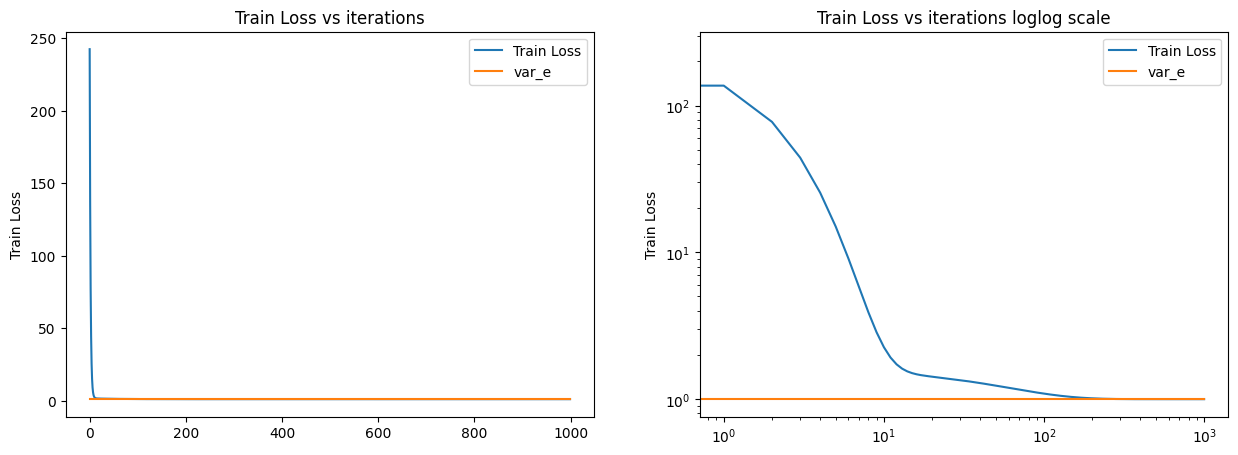

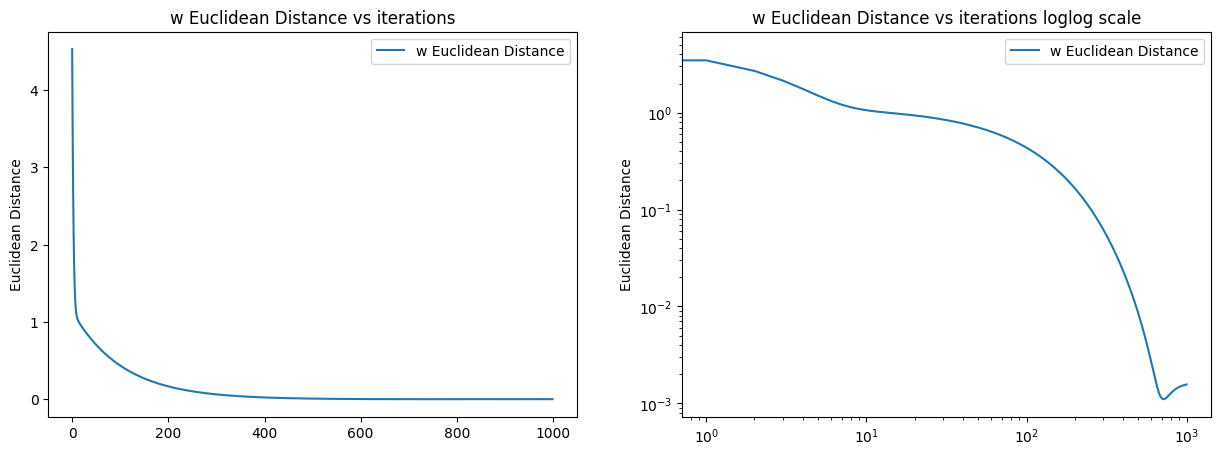

In [38]:
# We start by looking at GD and we will play a little bit with the learning rate to see how this affects convergence
loss = lambda x, y: ((x-y)**2).mean()
linear_model = Linear_Model(p=A.shape[1])
gd = GD_Algorithm(linear_model, T=1000, X=measurements[0], Y=measurements[1] , eta=0.01, loss=loss)
w_gd = run_optimization(gd)

fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(gd.losses_history, label='Train Loss')
axes[0].plot(var_e * np.ones((len(gd.losses_history),1)), label='var_e')
axes[0].legend(), axes[0].set_ylabel('Train Loss'), axes[0].set_title('Train Loss vs iterations')
axes[1].plot(gd.losses_history, label='Train Loss')
axes[1].plot(var_e * np.ones((len(gd.losses_history),1)), label='var_e')
axes[1].set_yscale('log'), axes[1].set_xscale('log')
axes[1].legend(), axes[1].set_ylabel('Train Loss'), axes[1].set_title('Train Loss vs iterations loglog scale')

# Let's evaluate the distance measured using the euclidean distance between w_t and the optimal parameter A (we are
# assuming the minimum exists and is unique, existence is trivial but uniqueness depends on the rank of X^T X)
w_distance = np.sqrt(((np.array(gd.w_history).squeeze(-1) - A)**2).sum(1))
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(w_distance, label='w Euclidean Distance')
axes[0].legend(), axes[0].set_ylabel('Euclidean Distance'), axes[0].set_title('w Euclidean Distance vs iterations')
axes[1].plot(w_distance, label='w Euclidean Distance')
axes[1].set_yscale('log'), axes[1].set_xscale('log')
axes[1].legend(), axes[1].set_ylabel('Euclidean Distance'), axes[1].set_title('w Euclidean Distance vs iterations loglog scale')

In [39]:
# TODO 4 Play a little bit with the code below and try to find which is the fastest eta possible. Simply change 'etas'
# (you can change also T)

# Let's now try to understand the effects of the learning rate eta on the convergence speed
etas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 10]

linear_models = [Linear_Model(p=A.shape[1]) for _ in range(len(etas))]
gd_list = [GD_Algorithm(model, T=3000, X=measurements[0], Y=measurements[1] , eta=eta, loss=loss) for eta, model in 
                                                                                             zip(etas, linear_models)]
w_opt_gd_list = [run_optimization(gd) for gd in gd_list]

# Warnings may be a signal of instability... See Markdown cell below!

c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in matmul
c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in matmul
c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in subtract
c:\Users\Nih

c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\numpy\ma\core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


(None, None)

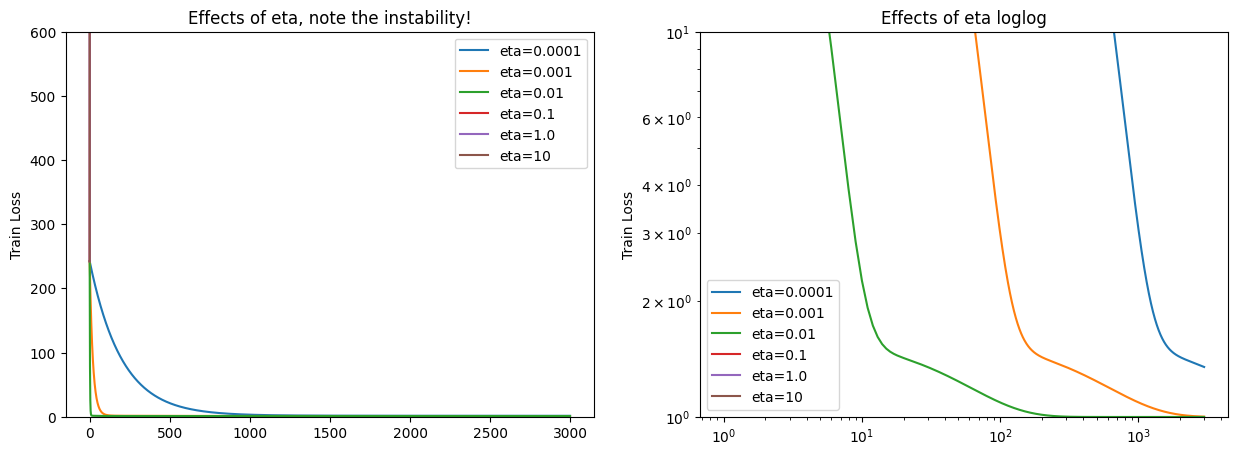

In [40]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
[axes[0].plot(gd.losses_history, label=f'eta={eta}') for eta, gd in zip(etas, gd_list)]
axes[0].legend(), axes[0].set_ylabel('Train Loss'), axes[0].set_title('Effects of eta, note the instability!')
axes[0].set_ylim(0, 600)
[axes[1].plot(gd.losses_history, label=f'eta={eta}') for eta, gd in zip(etas, gd_list)]
axes[1].legend(), axes[1].set_ylabel('Train Loss'), axes[1].set_title('Effects of eta loglog')
axes[1].set_yscale('log'), axes[1].set_xscale('log')

### Instability of GD for large eta
Why do we have instability for high $\eta$? 

We know that GD dynamics is equivalent to (have a look at previous LS Markdown cell) a linear dynamical systems whose state transition matrix is $(I - \frac{2 \eta}{m} X^T X)$. If the spectrum of
this matrix has some non stable eigenvalue then GD dynamics will become unstable. 

Let $\Lambda(I - \frac{2 \eta}{m} X^T X)$ be the spectrum of the matrix $I - \frac{2 \eta}{m} X^T X$, the following relation is trivially true: 
$$\Lambda(I - \frac{2 \eta}{m} X^T X) = I - \Lambda(\frac{2 \eta}{m} X^T X) = I - \frac{2 \eta}{m}\Lambda(X^T X)$$

Now remember $\Lambda(X^T X) \geq 0$ (since this is a p.s.d. matrix). This means that it exists a certain $\eta$ from which the system will not be anymore stable (for larger $\eta$). In fact the linear system will have a pole smaller that -1 (what matters here is that the pole's absolute value is greater than 1) and therefore the dynamics will not be stable anymore.

In [41]:
# TODO 5
# The maximum eigenvalue of X^T X rules the stability since it is the first one which will drive the system to 
# instability. What is the critical eigenvalue? Find it, try to run gd with it (and try to slighlty perturb it)!
eig, _ = np.linalg.eig(2 / measurements[0].shape[0] * np.matmul(measurements[0].T, measurements[0]))
print(eig)
# YOUR CODE HERE
eta_critical = 1 / eig[0]
print(eta_critical)

[25.06861822  0.9528206 ]
0.03989051136249664


In [42]:
# We now will see the effects on SGD of learning rate and batch size (very similar to previous cells)

# TODO 6 Play a little bit with the code below and try to find which is the fastest eta possible. Simply change 'etas'
# (you can change also T). Note the different 'noisy' behaviour of the loss for different values of eta. Why the 
# higher the learning rate the larger the noise? 
etas = [1e0, 1e-1, 1e-2, 39e-3 , 1e-3, 1e-4]
fixed_bs = 5

linear_models = [Linear_Model(p=A.shape[1]) for _ in range(len(etas))]
sgd_list = [SGD_Algorithm(model, T=5000, X=measurements[0], Y=measurements[1] , eta=eta, loss=loss, batch_size=fixed_bs) 
                                                                            for eta, model in zip(etas, linear_models)]
w_opt_sgd_list = [run_optimization(sgd) for sgd in sgd_list]

c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in matmul
c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in matmul
c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0

Questions: 
1. We mentioned that larger the learning rate, larger the noise, but the noise at the critical learning rate which is 1/max(eig(X^tX)) is much larger, at eta critical convergence is the quickest? how do we interpret that, because the convergence is the fastest and the noise is the most 
2. Batch size variability, larger batch size more cost and is performing better but is getting more close to GD 
3. Batch size can be chosen on computing power? due to parrallel computing and not sequential, the cost to pay per iteration doesn't change for 1 or several
4. Can larger batch size overfit the data? 

c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in square
  
c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in square


(1e-05, 200)

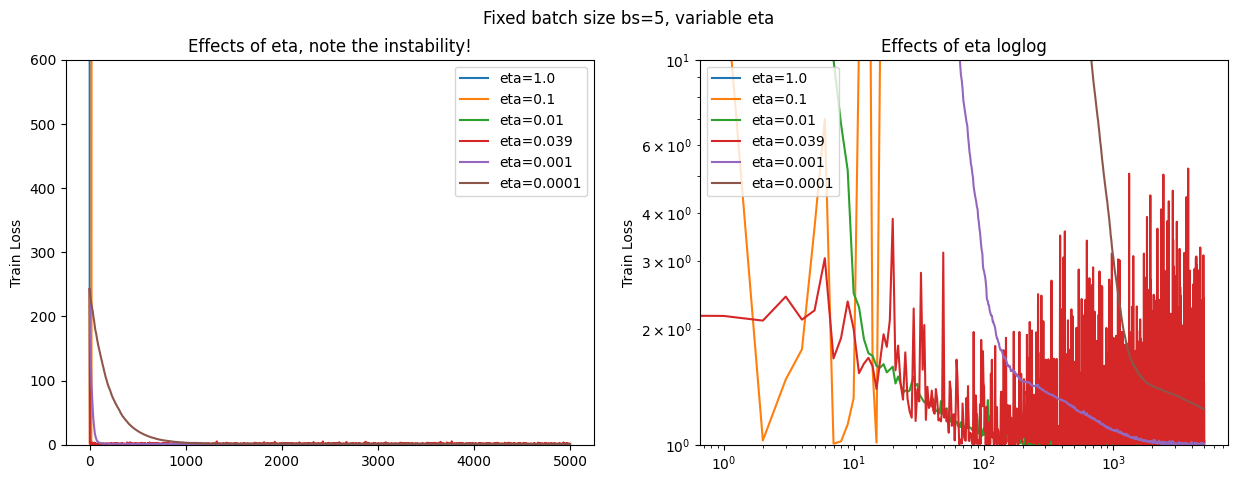

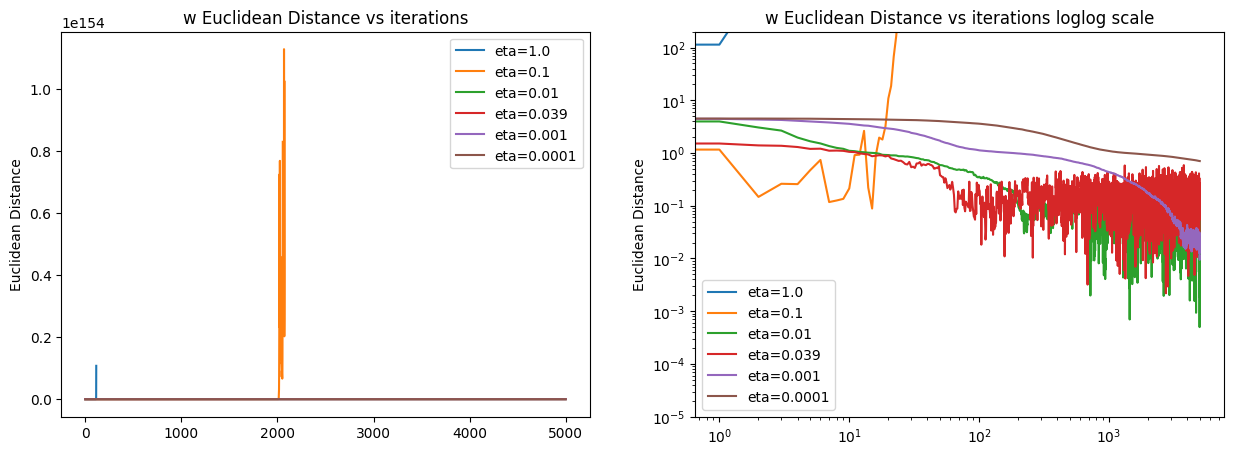

In [43]:
# training loss
fig, axes = plt.subplots(1,2, figsize=(15,5))
[axes[0].plot(sgd.losses_history, label=f'eta={eta}') for eta, sgd in zip(etas, sgd_list)]
axes[0].legend(), axes[0].set_ylabel('Train Loss'), axes[0].set_title('Effects of eta, note the instability!')
axes[0].set_ylim(0, 600)
[axes[1].plot(sgd.losses_history, label=f'eta={eta}') for eta, sgd in zip(etas, sgd_list)]
axes[1].legend(), axes[1].set_ylabel('Train Loss'), axes[1].set_title('Effects of eta loglog')
axes[1].set_yscale('log'), axes[1].set_xscale('log')
fig.suptitle('Fixed batch size bs=' + str(fixed_bs) + ', variable eta')

# distance from optimum
fig, axes = plt.subplots(1,2, figsize=(15,5))
for i, eta in enumerate(etas):
    w_distance = np.sqrt(((np.array(sgd_list[i].w_history).squeeze(-1) - A)**2).sum(1))
    axes[0].plot(w_distance, label=f'eta={eta}')
axes[0].legend(), axes[0].set_ylabel('Euclidean Distance'), axes[0].set_title('w Euclidean Distance vs iterations')

for i, eta in enumerate(etas):
    w_distance = np.sqrt(((np.array(sgd_list[i].w_history).squeeze(-1) - A)**2).sum(1))
    axes[1].plot(w_distance, label=f'eta={eta}')
axes[1].set_yscale('log'), axes[1].set_xscale('log')
axes[1].legend(), axes[1].set_ylabel('Euclidean Distance'), axes[1].set_title('w Euclidean Distance vs iterations loglog scale')
axes[1].set_ylim(1e-5,200)

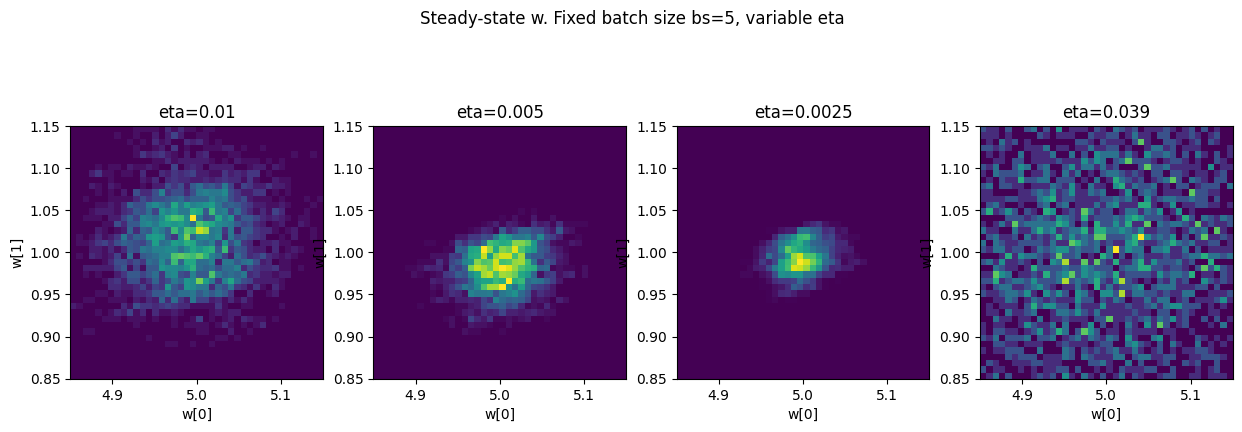

In [44]:
# histogram of decision vector at steady-state

etas = [1e-2, 1e-2/2, 1e-2/4, 39e-3]
fixed_bs = 5
linear_models = [Linear_Model(p=A.shape[1]) for _ in range(len(etas))]
sgd_list = [SGD_Algorithm(model, T=15000, X=measurements[0], Y=measurements[1] , eta=eta, loss=loss, batch_size=fixed_bs) 
                                                                            for eta, model in zip(etas, linear_models)]
w_opt_sgd_list = [run_optimization(sgd) for sgd in sgd_list]

steady_state_iter = 11000

fig, axes = plt.subplots(1,len(etas), figsize=(15,5))
fig.suptitle('Steady-state w. Fixed batch size bs=' + str(fixed_bs) + ', variable eta')
radius = 0.15
for i, eta in enumerate(etas):
    H, xedges, yedges = np.histogram2d(np.hstack(sgd_list[i].w_history)[0][steady_state_iter:],
                                       np.hstack(sgd_list[i].w_history)[1][steady_state_iter:],
                                       bins=40, range=[A[0,0]+[-radius, +radius], A[0,1]+[-radius, radius]])
    axes[i].imshow(H.T, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    axes[i].set_title('eta=' + str(eta))
    axes[i].set(xlabel='w[0]', ylabel='w[1]')

In [45]:
# We now will see the effect on SGD of batch size (very similar to previous cells)

# TODO 7 Play a little bit with the code below and try to find which is the fastest batch size possible. 
# Simply change 'BSs' (you can change also T). Note the different 'noisy' behaviour of the loss for different values 
# of batch size. Why the smaller the batch size the larger the noise? 
BSs = [1, 5, 100, 500, 1000]
fixed_eta = 0.01

linear_models = [Linear_Model(p=A.shape[1]) for _ in range(len(BSs))]
sgd_list = [SGD_Algorithm(model, T=5000, X=measurements[0], Y=measurements[1] , eta=fixed_eta, loss=loss, batch_size=bs) 
                                                                            for bs, model in zip(BSs, linear_models)]
w_opt_sgd_list = [run_optimization(sgd) for sgd in sgd_list]

(1e-05, 200)

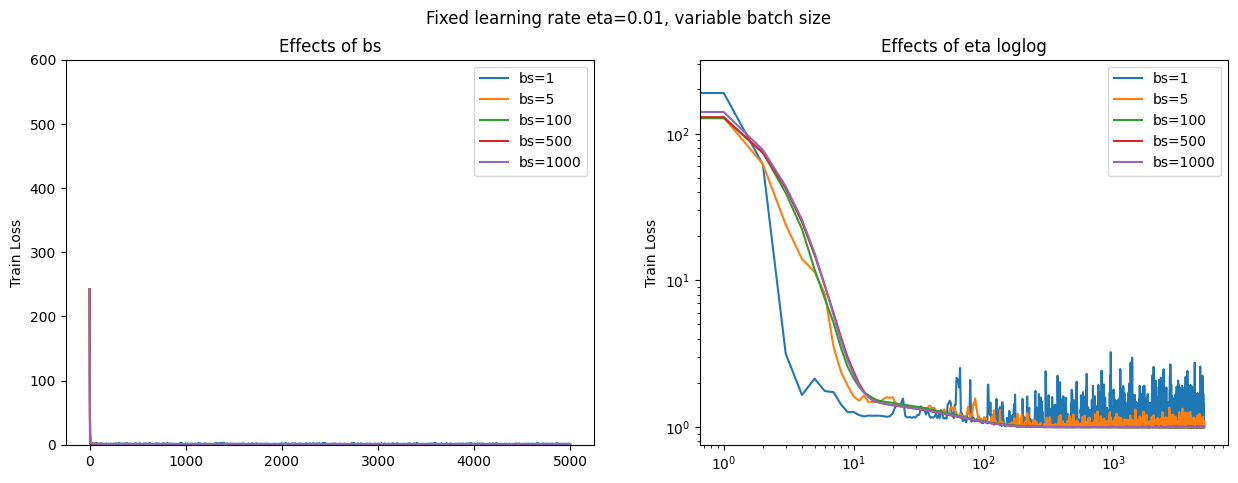

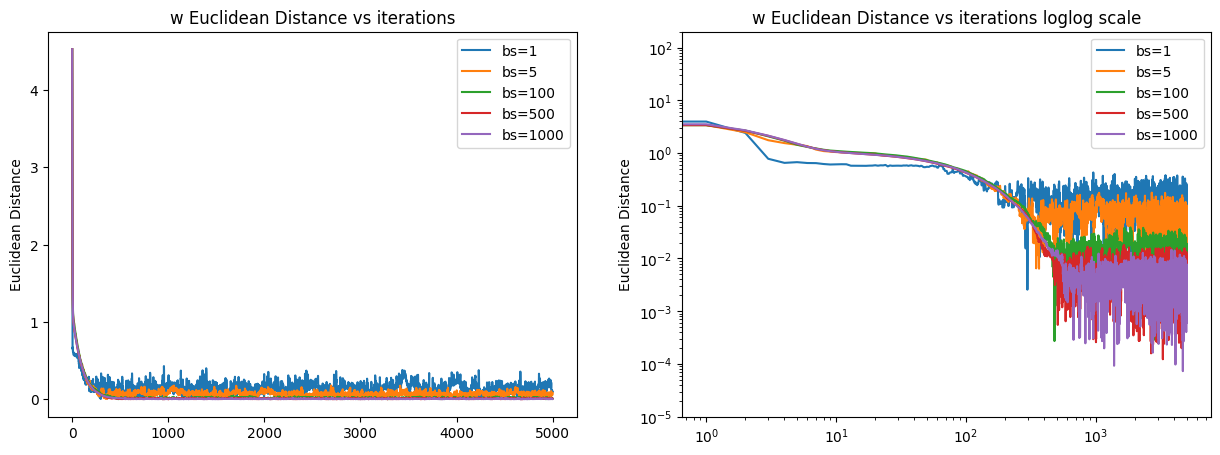

In [46]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
[axes[0].plot(sgd.losses_history, label=f'bs={bs}') for bs, sgd in zip(BSs, sgd_list)]
axes[0].legend(), axes[0].set_ylabel('Train Loss'), axes[0].set_title('Effects of bs')
axes[0].set_ylim(0, 600)
[axes[1].plot(sgd.losses_history, label=f'bs={bs}') for bs, sgd in zip(BSs, sgd_list)]
axes[1].legend(), axes[1].set_ylabel('Train Loss'), axes[1].set_title('Effects of eta loglog')
axes[1].set_yscale('log'), axes[1].set_xscale('log')
fig.suptitle('Fixed learning rate eta=' + str(fixed_eta) + ', variable batch size')

fig, axes = plt.subplots(1,2, figsize=(15,5))
for i, bs in enumerate(BSs):
    w_distance = np.sqrt(((np.array(sgd_list[i].w_history).squeeze(-1) - A)**2).sum(1))
    axes[0].plot(w_distance, label=f'bs={bs}')
axes[0].legend(), axes[0].set_ylabel('Euclidean Distance'), axes[0].set_title('w Euclidean Distance vs iterations')

for i, bs in enumerate(BSs):
    w_distance = np.sqrt(((np.array(sgd_list[i].w_history).squeeze(-1) - A)**2).sum(1))
    axes[1].plot(w_distance, label=f'bs={bs}')
axes[1].set_yscale('log'), axes[1].set_xscale('log')
axes[1].legend(), axes[1].set_ylabel('Euclidean Distance'), axes[1].set_title('w Euclidean Distance vs iterations loglog scale')
axes[1].set_ylim(1e-5,200)

([Text(0.5, 0, 'w[0]'), Text(0, 0.5, 'w[1]')],
 [Text(0.5, 0, 'w[0]'), Text(0, 0.5, 'w[1]')])

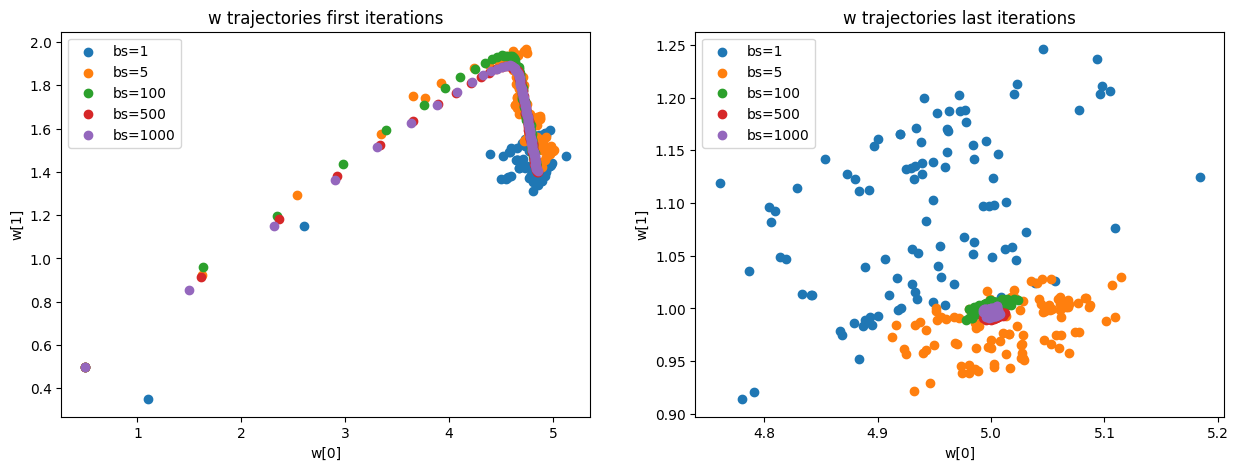

In [47]:
# Let's see the effects of batch size on parameters trajectories distribution
early_w_trajectories = [np.array(sgd.w_history[:100]).squeeze(-1) for sgd in sgd_list]
late_w_trajectories = [np.array(sgd.w_history[-100:]).squeeze(-1) for sgd in sgd_list]
fig, axes = plt.subplots(1,2, figsize=(15,5))
[axes[0].scatter(w_trajectory[:,0], w_trajectory[:,1], label=f'bs={bs}') for bs, w_trajectory in zip(BSs, early_w_trajectories)]
[axes[1].scatter(w_trajectory[:,0], w_trajectory[:,1], label=f'bs={bs}') for bs, w_trajectory in zip(BSs, late_w_trajectories)]
axes[0].legend(), axes[1].legend()
axes[0].set_title('w trajectories first iterations'), axes[1].set_title('w trajectories last iterations')
axes[0].set(xlabel='w[0]', ylabel='w[1]'), axes[1].set(xlabel='w[0]', ylabel='w[1]')

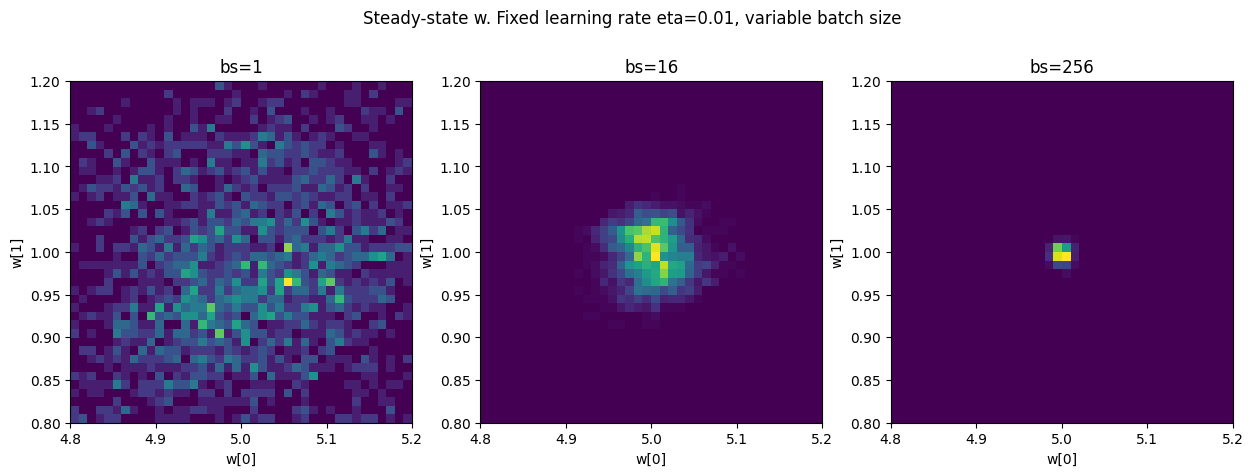

In [48]:
# histogram of decision vector at steady-state
BSs = [1, 16, 256]
fixed_eta = 0.01
linear_models = [Linear_Model(p=A.shape[1]) for _ in range(len(BSs))]
sgd_list = [SGD_Algorithm(model, T=5000, X=measurements[0], Y=measurements[1] , eta=fixed_eta, loss=loss, batch_size=bs) 
                                                                            for bs, model in zip(BSs, linear_models)]
w_opt_sgd_list = [run_optimization(sgd) for sgd in sgd_list]

steady_state_iter = 2000

fig, axes = plt.subplots(1,len(BSs), figsize=(15,5))
fig.suptitle('Steady-state w. Fixed learning rate eta=' + str(fixed_eta) + ', variable batch size')
radius = 0.2
for i, bs in enumerate(BSs):
    H, xedges, yedges = np.histogram2d(np.hstack(sgd_list[i].w_history)[0][steady_state_iter:],
                                       np.hstack(sgd_list[i].w_history)[1][steady_state_iter:],
                                       bins=40, range=[A[0,0]+[-radius, +radius], A[0,1]+[-radius, radius]])
    axes[i].imshow(H.T, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    axes[i].set_title('bs=' + str(bs))
    axes[i].set(xlabel='w[0]', ylabel='w[1]')

Effect of $\eta$ and $B$ on the variance of $\hat{w}$:

- The batch size $B$ makes the variance proportional to $1 / B$ 
- The learning rate $\eta$ makes the variance proportional to $\eta^2$

$\rightarrow$ what matters is the ratio $\frac{\eta^2}{B}$ !

etas:  [0.01264911 0.02529822 0.05059644]


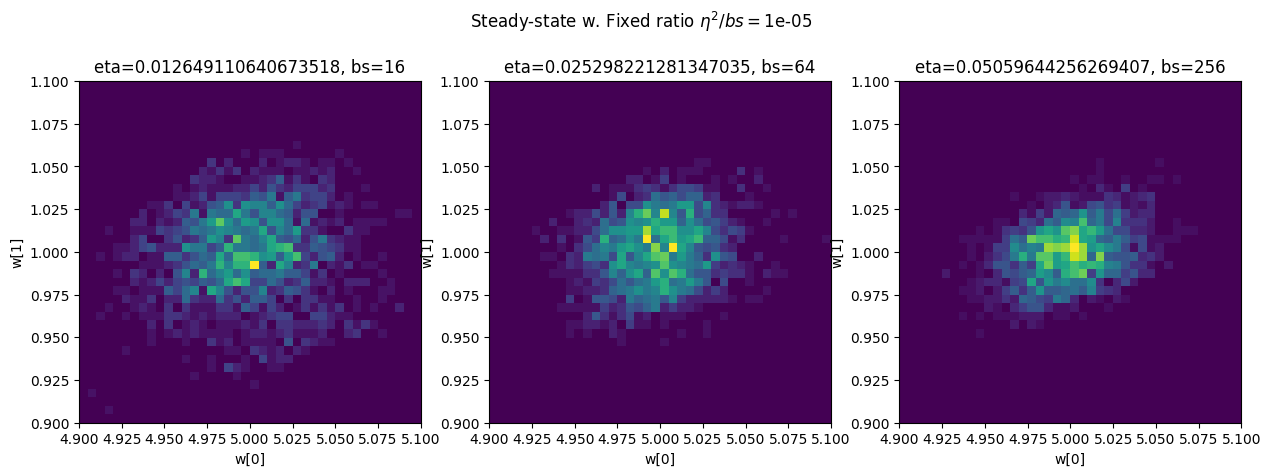

In [49]:
fixed_ratio = 1e-5
BSs = np.array([16, 64, 256])
etas = np.sqrt(BSs * fixed_ratio)

print('etas: ', etas)

linear_models = [Linear_Model(p=A.shape[1]) for _ in range(len(etas))]
sgd_list = [SGD_Algorithm(model, T=30000, X=measurements[0], Y=measurements[1] , eta=eta, loss=loss, batch_size=bs) 
                                                                            for eta, bs, model in zip(etas, BSs, linear_models)]
np.random.seed(101)
w_opt_sgd_list = [run_optimization(sgd) for sgd in sgd_list]

steady_state_iter = 28000

fig, axes = plt.subplots(1, len(BSs), figsize=(15,5))
fig.suptitle('Steady-state w. Fixed ratio $\eta^2 / bs =$' + str(fixed_ratio))
radius = 0.1
for i, bs in enumerate(BSs):
    H, xedges, yedges = np.histogram2d(np.hstack(sgd_list[i].w_history)[0][steady_state_iter:],
                                       np.hstack(sgd_list[i].w_history)[1][steady_state_iter:],
                                       bins=40, range=[A[0,0]+[-radius, radius], A[0,1]+[-radius, radius]])
    axes[i].imshow(H.T, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    axes[i].set_title(f'eta={etas[i]}, bs={bs}')
    axes[i].set(xlabel='w[0]', ylabel='w[1]')

In [50]:
# Is it faster GD or SGD (measuring the number of iterations and the computational complexity)
model_gd = Linear_Model(p=A.shape[1])
gd = GD_Algorithm(model_gd, T=1000, X=measurements[0], Y=measurements[1] , eta=0.01, loss=loss)

model_sgd = Linear_Model(p=A.shape[1])
sgd = SGD_Algorithm(model_sgd, T=1000, X=measurements[0], Y=measurements[1] , eta=0.01, loss=loss, batch_size=5)

import time 
start_time = time.time()
run_optimization(gd)
time_to_run_gd = time.time() - start_time
start_time = time.time()
run_optimization(sgd)
time_to_run_sgd = time.time() - start_time
print(f'Time to run gd  {time_to_run_gd:.4f}, Loss on the last 500 iterations {np.array(gd.losses_history[-500:]).mean():.4f}')
print(f'Time to run sgd {time_to_run_sgd:.4f}, Loss on the last 500 iterations {np.array(sgd.losses_history[-500:]).mean():.4f}')
# SGD is almost twice as fast and 3% less accurate 

Time to run gd  1.1318, Loss on the last 500 iterations 0.9983
Time to run sgd 0.7331, Loss on the last 500 iterations 1.0340


(<matplotlib.legend.Legend at 0x24f48e31848>,
 Text(0.5, 1.0, 'GD vs SGD'),
 Text(0, 0.5, 'Train Loss'),
 Text(0.5, 0, 'Iterations'))

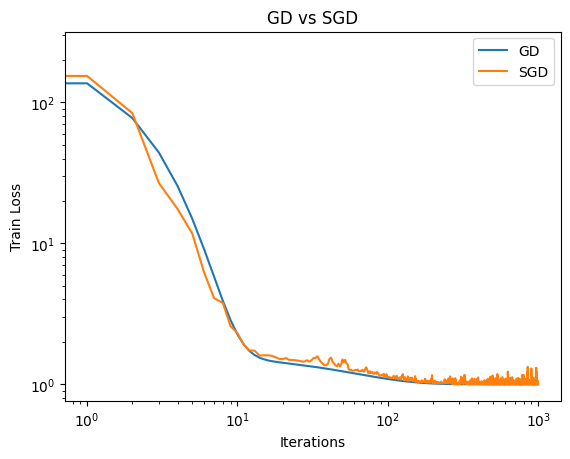

In [51]:
plt.loglog(gd.losses_history, label='GD')
plt.loglog(sgd.losses_history, label='SGD')
plt.legend(), plt.title('GD vs SGD'), plt.ylabel('Train Loss'), plt.xlabel('Iterations')

[Text(0.5, 0, 'w[0]'), Text(0, 0.5, 'w[1]')]

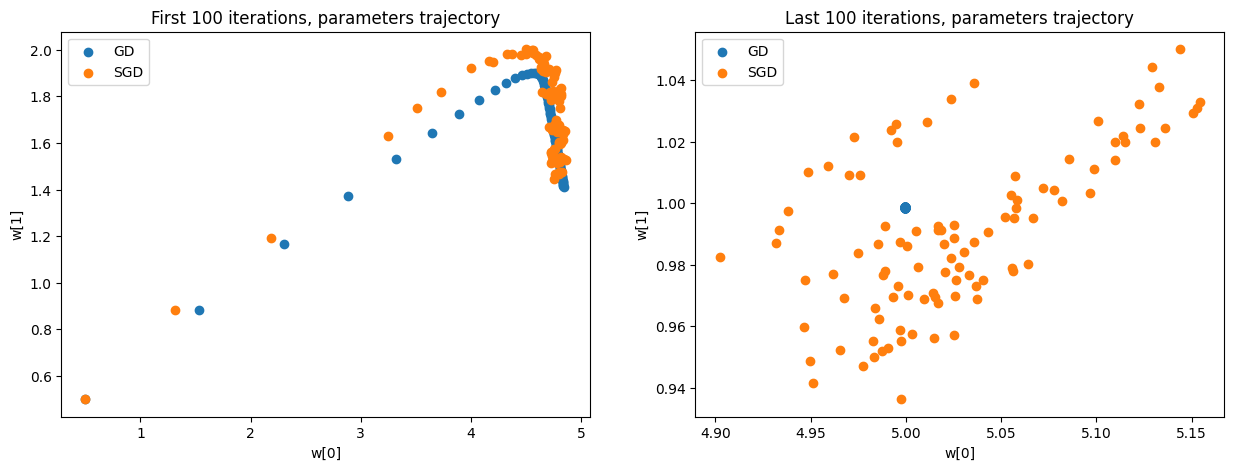

In [52]:
# Scatter plot of the trajectories of GD vs SGD and see stationary distribution

window = 100  # plot first and last <window> models

fig, axes = plt.subplots(1,2, figsize=(15,5))
gd_w_history = np.array(gd.w_history[:window]).squeeze(-1)
sgd_w_history = np.array(sgd.w_history[:window]).squeeze(-1)
axes[0].scatter(gd_w_history[:,0], gd_w_history[:,1], label='GD')
axes[0].scatter(sgd_w_history[:,0], sgd_w_history[:,1], label='SGD')
axes[0].legend(), axes[0].set_title('First 100 iterations, parameters trajectory')
axes[0].set(xlabel='w[0]', ylabel='w[1]')

gd_w_history = np.array(gd.w_history[-window:]).squeeze(-1)
sgd_w_history = np.array(sgd.w_history[-window:]).squeeze(-1)
axes[1].scatter(gd_w_history[:,0], gd_w_history[:,1], label='GD')
axes[1].scatter(sgd_w_history[:,0], sgd_w_history[:,1], label='SGD')
axes[1].legend(), axes[1].set_title('Last 100 iterations, parameters trajectory')
axes[1].set(xlabel='w[0]', ylabel='w[1]')

Questions: 
1. We mentioned that larger the learning rate, larger the noise, but the noise at the critical learning rate which is 1/max(eig(X^tX)) is much larger, at eta critical convergence is the quickest? how do we interpret that, because the convergence is the fastest and the noise is the most 
2. Batch size variability, larger batch size more cost and is performing better but is getting more close to GD 
3. Batch size can be chosen on computing power? due to parrallel computing and not sequential, the cost to pay per iteration doesn't change for 1 or several
4. Can larger batch size overfit the data? 